# Riparian Connectivity - Analysis Workflow Prototype



## Imports and Setup

Author: John

In [37]:
# Imports
# -------

import geopandas as gpd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rioxarray as rxr

In [38]:
# Create paths
# ------------

# sample1 or sample2
# This will specify whether sample1 or sample2 datasets are used
sample = "sample2"

# Create path to input vector data
input_gpkg_path = os.path.join(f"sample_data", 
                               f"{sample}.gpkg")

# Create path to input raster data
input_raster_path = os.path.join("sample_data",
                                f"PN_S2_{sample}.tif")

# Create path to intermediate results GeoPackage
intermed_gpkg_path = os.path.join("intermediate_outputs", "geopackages",
                                          f"intermediate_outputs-{sample}.gpkg")

# Create path to intermediate results figures directory
intermed_figures_path = os.path.join("intermediate_outputs", "figures")


# Create path to intermediate results imagery directory
intermed_imagery_path = os.path.join("intermediate_outputs", "imagery")

# Create path to intermediate results tables
intermed_tables_path = os.path.join("intermediate_outputs", "tables")

## 1) Read the Sentinel-2 Raster

Author: John

This is done first so the Sentinel-2 imagery's CRS can be use to reproject the vector data. Reprojecting a raster requires resampling and thus there are changes to pixel values - reprojecting vector data doesn't cause any changes in the vector data's values.

In [39]:
# Read Sentinel-2 raster into a DataArray
# ---------------------------------------

sentinel2_da = rxr.open_rasterio(filename=input_raster_path)

sentinel2_da

<xarray.DataArray (band: 16, y: 1175, x: 1174)>
[22071200 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * x            (x) float64 4.09e+05 4.09e+05 4.09e+05 ... 4.19e+05 4.19e+05
  * y            (y) float64 5.083e+06 5.083e+06 ... 5.073e+06 5.073e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    3.3999999521443642e+38
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('pn_imagec1', 'pn_imagec2', 'pn_imagec3', 'pn_imagec4', '...

In [40]:
# Get the CRS of the Sentinel-2 DataArray

sentinel2_crs = sentinel2_da.rio.crs
sentinel2_crs

CRS.from_epsg(2951)

In [41]:
# Rename the long_name attributes to be more descriptive
# Specs from here: https://en.wikipedia.org/wiki/Sentinel-2

sentinel2_da.attrs["long_name"] = ("B1  | 60m | Coastal and Aerosol",
                                   "B2  | 10m | Blue",
                                   "B3  | 10m | Green",
                                   "B4  | 10m | Red",
                                   "B5  | 20m | Vegetation Red Edge",
                                   "B6  | 20m | Vegetation Red Edge",
                                   "B7  | 20m | Vegetation Red Edge",
                                   "B8  | 10m | NIR",
                                   "B8a | 20m | Narrow NIR",
                                   "B9  | 60m | Water vapour",
                                   "B10 | 60m | SWIR – Cirrus",
                                   "B11 | 20m | SWIR",
                                   "B12 | 20m | SWIR",
                                   "B13",
                                   "B14",
                                   "B15")

sentinel2_da

<xarray.DataArray (band: 16, y: 1175, x: 1174)>
[22071200 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * x            (x) float64 4.09e+05 4.09e+05 4.09e+05 ... 4.19e+05 4.19e+05
  * y            (y) float64 5.083e+06 5.083e+06 ... 5.073e+06 5.073e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    3.3999999521443642e+38
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B1  | 60m | Coastal and Aerosol', 'B2  | 10m | Blue', 'B...

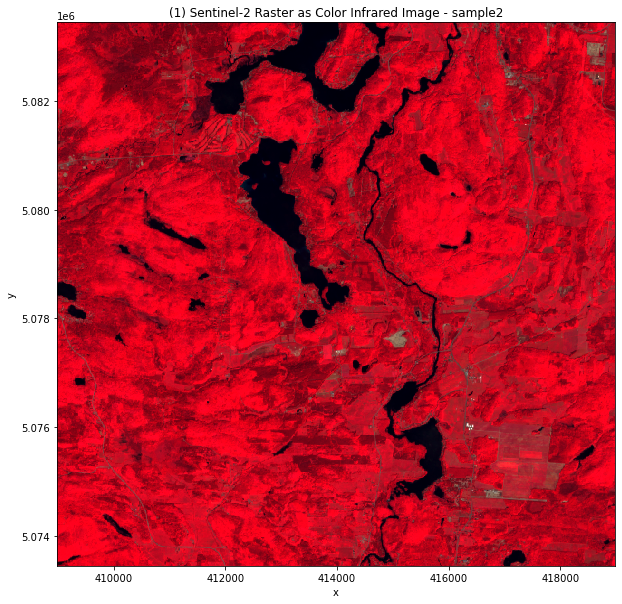

In [42]:
# Plot the Sentinel-2 DataArray as a Color Infared Image)
# ----------------------------------------------------------

# Select NIR, Red, and Green bands (8, 4, 3)
rgb_da = sentinel2_da.sel(band=[8,4,3])

# Plot the image
rgb_da.plot.imshow(figsize=(10,10), robust=True)

# Add plot elements
plt.title(f"(1) Sentinel-2 Raster as Color Infrared Image - {sample}")

# Save figure
fig_path = os.path.join(intermed_figures_path, f"1-color_infared-{sample}.png")
plt.savefig(fig_path)

## 2) Read and Reproject the Water Bodies, Water Courses, and Boundary Vectory Data

Authors: Ben, John

In [43]:
# Read the vector data
# --------------------

# Read the GeoPackage layers
boundary_gdf = gpd.read_file(filename=input_gpkg_path,
                                layer=f"boundary_{sample}")

waterbodies_gdf = gpd.read_file(filename=input_gpkg_path,
                                layer=f"water_bodies_{sample}")

watercourses_gdf = gpd.read_file(filename=input_gpkg_path,
                                layer=f"water_courses_{sample}")

In [44]:
# Reproject the vector data to the Sentinel-2 CRS

boundary_gdf = boundary_gdf.to_crs(sentinel2_crs)
waterbodies_gdf = waterbodies_gdf.to_crs(sentinel2_crs)
watercourses_gdf = watercourses_gdf.to_crs(sentinel2_crs)

# Save the intermediate output
boundary_gdf.to_file(filename=intermed_gpkg_path,
                        layer=f"2-boundary-reproj-{sample}")

waterbodies_gdf.to_file(filename=intermed_gpkg_path,
                           layer=f"2-waterbodies-reproj-{sample}")

watercourses_gdf.to_file(filename=intermed_gpkg_path,
                            layer=f"2-watercourses-reproj-{sample}")

/Users/johnofoster/opt/miniconda3/envs/riparian_dev/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/johnofoster/opt/miniconda3/envs/riparian_dev/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/johnofoster/opt/miniconda3/envs/riparian_dev/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


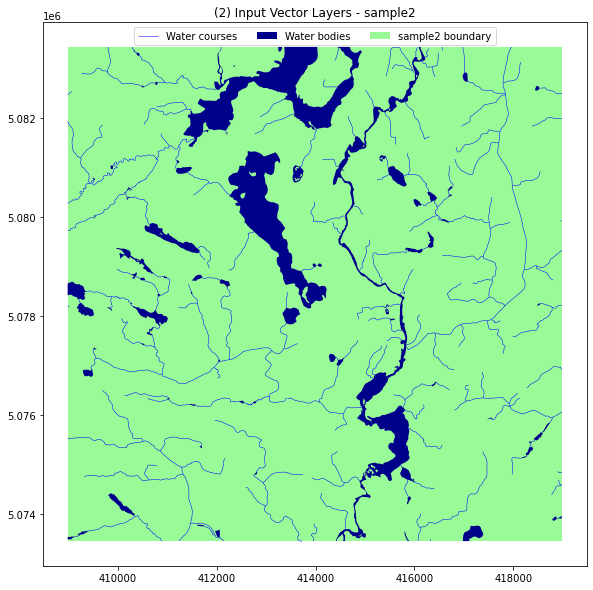

In [45]:
# Plot the boundary, water bodies, and water courses
# -------------------------------------------------

# Layer styles
boundary_style = {"facecolor": "palegreen",
                  "edgecolor": "none",
                  "label": f"{sample} boundary"}

waterbodies_style = {"facecolor": "darkblue",
                     "edgecolor": "none",                
                     "label": "Water bodies"}

watercourses_style = {"facecolor": "blue",
                      "edgecolor": "none",
                      "label": "Water courses"}

# Plot figure
ax = boundary_gdf.plot(color=boundary_style["facecolor"],
                       label=boundary_style["label"],
                       figsize=(10, 10),
                       legend_kwds={'loc': 'center left'})

waterbodies_gdf.plot(ax=ax,
                     color=waterbodies_style["facecolor"],
                     label=waterbodies_style["label"])

watercourses_gdf.plot(ax=ax,
                      color=watercourses_style["facecolor"],
                      label=watercourses_style["label"],
                      linewidth=0.5)

# Add figure elements
ax.set_title(label=f"(2) Input Vector Layers - {sample}")

# Create polygon legend elements
waterbodies_handle = Patch(**waterbodies_style)
boundary_handle = Patch(**boundary_style)
handles, _ = ax.get_legend_handles_labels()

# Add legend
ax.legend(loc="upper center", ncol=4,
          handles=[*handles,
                   waterbodies_handle,
                   boundary_handle])

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"2-input_vector_layers-{sample}.png")
plt.savefig(fig_path)

## 3) Buffer the Water Bodies and Water Courses

Authors: Ben, John

In [46]:
# User inputs
# -----------

# User input buffer width for the riparian buffer
buffer_width_m = 50

In [47]:
# Peform buffer on the water bodies and water courses, dissolve the results, and clip
# to the boundary
# -------------------------------------------------------

# Create water bodies and water courses buffer geometry
waterbodies_buff_geom = waterbodies_gdf.buffer(buffer_width_m)
watercourses_buff_geom = watercourses_gdf.buffer(buffer_width_m)

# Create new GeoDataFrames containing the dissolved buffer geometries
waterbodies_buff_gdf = (gpd.GeoDataFrame(geometry=waterbodies_buff_geom)
                        .dissolve()
                        .clip(mask=boundary_gdf))

watercourses_buff_gdf = (gpd.GeoDataFrame(geometry=watercourses_buff_geom)
                         .dissolve()
                         .clip(mask=boundary_gdf))

# Save the intermediate output
waterbodies_buff_gdf.to_file(filename=intermed_gpkg_path,
                        layer=f"3-{buffer_width_m}m_buffer_of_waterbodies-{sample}")

watercourses_buff_gdf.to_file(filename=intermed_gpkg_path,
                        layer=f"3-{buffer_width_m}m_buffer_of_watercourses-{sample}")

/Users/johnofoster/opt/miniconda3/envs/riparian_dev/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/johnofoster/opt/miniconda3/envs/riparian_dev/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


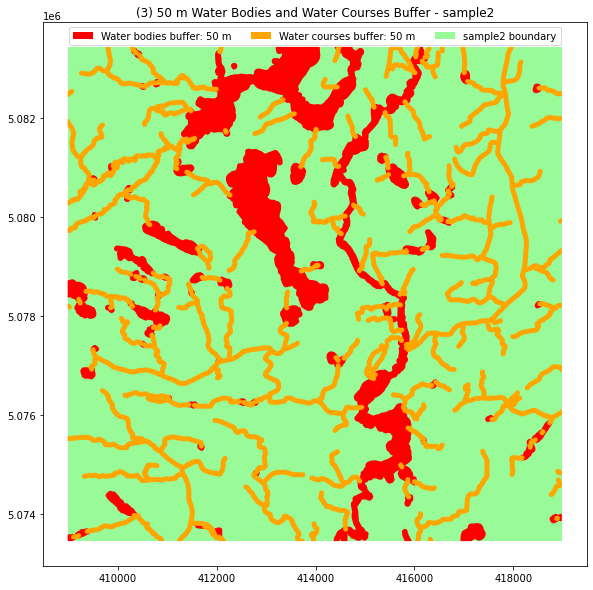

In [48]:
# Plot the buffered water bodies and water courses
# ----------------------------------

# Layer styles
boundary_style = {"facecolor": "palegreen",
                  "edgecolor": "none",
                  "label": f"{sample} boundary"}

waterbodies_buff_style = {"facecolor": "red",
                          "edgecolor": "none",                
                          "label": f"Water bodies buffer: {buffer_width_m} m"}

watercourses_buff_style = {"facecolor": "orange",
                           "edgecolor": "none",                
                           "label": f"Water courses buffer: {buffer_width_m} m"}


# Plot figure
ax = boundary_gdf.plot(color=boundary_style["facecolor"],
                       label=boundary_style["label"],
                       figsize=(10, 10),
                       legend_kwds={'loc': 'center left'})

waterbodies_buff_gdf.plot(ax=ax,
                          color=waterbodies_buff_style["facecolor"],
                          label=waterbodies_buff_style["label"],
                          linewidth=0.5)

watercourses_buff_gdf.plot(ax=ax,
                           color=watercourses_buff_style["facecolor"],
                           label=watercourses_buff_style["label"],
                           linewidth=0.5)

# Add figure elements
ax.set_title(label=f"(3) {buffer_width_m} m Water Bodies and Water Courses Buffer - {sample}")

# Create polygon legend elements
waterbodies_buff_handle = Patch(**waterbodies_buff_style)
watercourses_buff_handle = Patch(**watercourses_buff_style)
boundary_handle = Patch(**boundary_style)
handles, _ = ax.get_legend_handles_labels()

# Add legend
ax.legend(loc="upper center", ncol=4,
          handles=[*handles,
                   waterbodies_buff_handle,
                   watercourses_buff_handle,
                   boundary_handle])

# Save figure
fig_path = os.path.join(intermed_figures_path,
                f"3-{buffer_width_m}m_waterbodies_and_watercourses_buffer-{sample}.png")
plt.savefig(fig_path)

## 4) Peform Union on the Buffered Water Bodies and Water Courses

Authors: Ben, John

In [49]:
#  Peform union on the buffered water bodies and water courses
# ------------------------------------------------------------

water_buff_gdf = gpd.overlay(df1=waterbodies_buff_gdf,
                             df2=watercourses_buff_gdf,
                             how='union').dissolve()

# Save the intermediate output
water_buff_gdf.to_file(filename=intermed_gpkg_path,
                       layer=f"4-water_buffer-{sample}")

/Users/johnofoster/opt/miniconda3/envs/riparian_dev/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


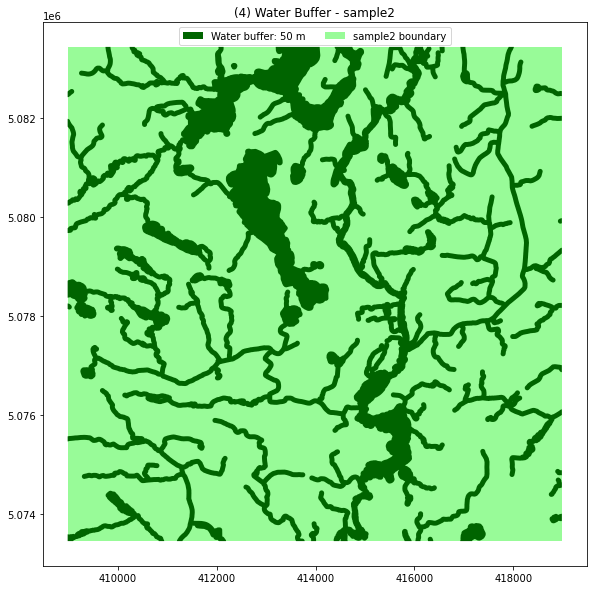

In [50]:
# Plot the union of the buffered water bodies and water courses
# -------------------------------------------------------------

# Layer styles
boundary_style = {"facecolor": "palegreen",
                  "edgecolor": "none",
                  "label": f"{sample} boundary"}

water_buff_style = {"facecolor": "darkgreen",
                    "edgecolor": "none",                
                    "label": f"Water buffer: {buffer_width_m} m"}

# Plot figure
ax = boundary_gdf.plot(color=boundary_style["facecolor"],
                       label=boundary_style["label"],
                       figsize=(10, 10),
                       legend_kwds={'loc': 'center left'})

water_buff_gdf.plot(ax=ax,
                      color=water_buff_style["facecolor"],
                      label=water_buff_style["label"],
                      linewidth=0.5)

# Add figure elements
ax.set_title(label=f"(4) Water Buffer - {sample}")

# Create polygon legend elements
water_buff_handle = Patch(**water_buff_style)
boundary_handle = Patch(**boundary_style)
handles, _ = ax.get_legend_handles_labels()

# Add legend
ax.legend(loc="upper center", ncol=4,
          handles=[*handles,
                   water_buff_handle,
                   boundary_handle])

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"4-{buffer_width_m}m_water_buffer-{sample}.png")
plt.savefig(fig_path)

## 5) Get the Difference Between the Water Buffer and Water Bodies; Clip to Boundary

Authors: Ben, John

In [51]:
# Get difference of buffered water bodies and water bodies to get the outer buffer

riparian_buff_gdf = gpd.overlay(df1=water_buff_gdf,
                           df2=waterbodies_gdf,
                           how='difference')

# Save the intermediate output
riparian_buff_gdf.to_file(filename=intermed_gpkg_path,
                     layer=f"5-riparian_buffer-{sample}")

/Users/johnofoster/opt/miniconda3/envs/riparian_dev/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


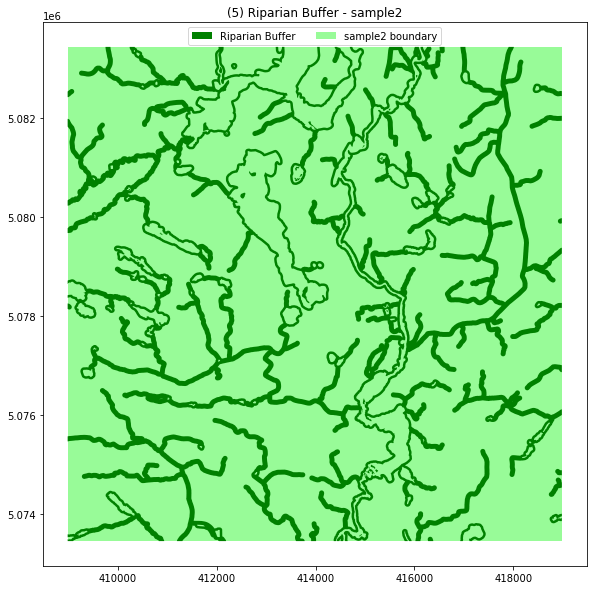

In [52]:
# 5 - Plot the boundary and riparian buffer
# -----------------------------------------

# Layer styles
boundary_style = {"facecolor": "palegreen",
                  "edgecolor": "none",
                  "label": f"{sample} boundary"}

riparian_style = {"facecolor": "green",
               "edgecolor": "none",                
               "label": f"Riparian Buffer"}

# Plot figure
ax = boundary_gdf.plot(color=boundary_style["facecolor"],
                       label=boundary_style["label"],
                       figsize=(10, 10),
                       legend_kwds={'loc': 'center left'})

riparian_buff_gdf.plot(ax=ax,
                      color=riparian_style["facecolor"],
                      label=riparian_style["label"],
                      linewidth=0.5)

# Add figure elements
ax.set_title(label=f"(5) Riparian Buffer - {sample}")

# Create polygon legend elements
riparian_handle = Patch(**riparian_style)
boundary_handle = Patch(**boundary_style)
handles, _ = ax.get_legend_handles_labels()

# Add legend
ax.legend(loc="upper center", ncol=4,
          handles=[*handles,
                   riparian_handle,
                   boundary_handle])

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"5-{buffer_width_m}m_riparian_buffer-{sample}.png")
plt.savefig(fig_path)


## 6) Clip the Sentinel-2 DataArray to the riparian buffer

Author: Ben, John

In [53]:
# Clip the Sentinel-2 DataArray to the riparian buffer
# --------------------------------------------------------

# Set the nodata value to be nan
sentinel2_da.attrs["_FillValue"] = np.nan

# Clip the DataArray
riparian_buff_da = sentinel2_da.rio.clip(geometries=riparian_buff_gdf.geometry)

# Save the intermediate output
riparian_buff_da_path = os.path.join(intermed_imagery_path,
                                     f"6-riparian_buffer-{sample}.tiff")
riparian_buff_da.rio.to_raster(riparian_buff_da_path)

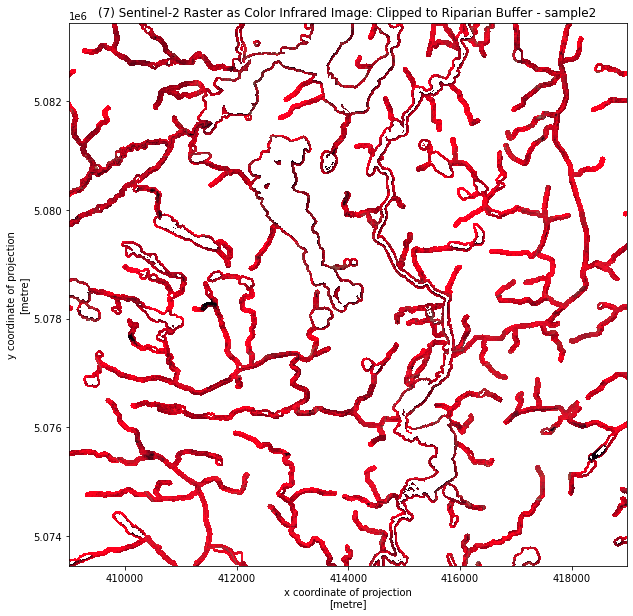

In [54]:
# 6 - Plot the clipped Sentinel-2 DataArray as a Color Infared Image)
# -------------------------------------------------------------------

# Select NIR, Red, and Green bands (8, 4, 3)
rgb_riparian_buff_da = riparian_buff_da.sel(band=[8,4,3])

# Plot the image
rgb_riparian_buff_da.plot.imshow(figsize=(10,10), robust=True)

# Add plot elements
plt.title(f"(7) Sentinel-2 Raster as Color Infrared Image: Clipped to Riparian Buffer - {sample}")

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"6-riparian_buffer-color_infared-{sample}.png")
plt.savefig(fig_path)

## 7) Extract the Red and NIR Bands

Authors: Haley, John

In [55]:
# Select the Red and NIR bands
# -----------------------------

# Select the Red band and keep only its long name attribute
red_da = riparian_buff_da.sel(band=4)
red_da.attrs['long_name'] = red_da.attrs['long_name'][3]

# Select the NIR band and keep only its long name attribute
nir_da = riparian_buff_da.sel(band=8)
nir_da.attrs['long_name'] = nir_da.attrs['long_name'][7]

# Save the intermediate output
red_da_path = os.path.join(intermed_imagery_path,
                           f"7-riparian_buffer-red_band_4-{sample}.tiff")
red_da.rio.to_raster(red_da_path)

nir_da_path = os.path.join(intermed_imagery_path,
                           f"7-riparian_buffer-nir_band_8-{sample}.tiff")
nir_da.rio.to_raster(nir_da_path)

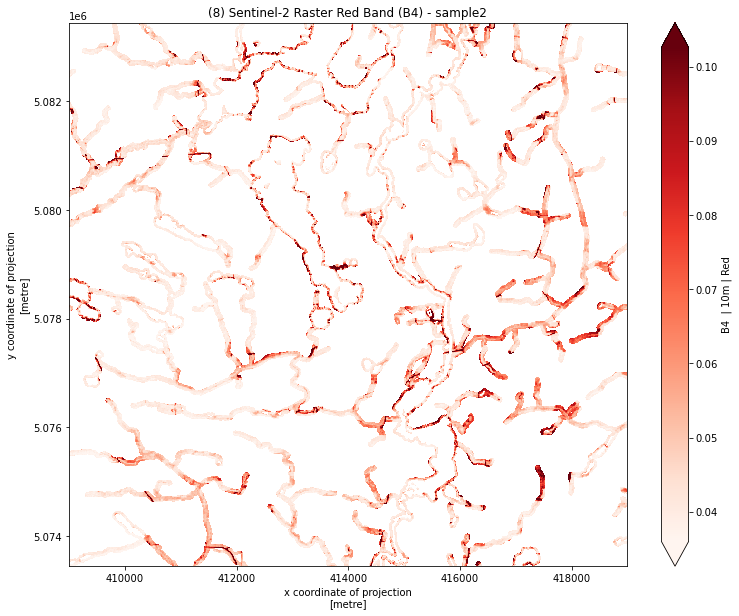

In [56]:
# Plot the Red band
# ---------------------

# Plot the image
red_da.plot.imshow(figsize=(12.5,10), robust=True, cmap=plt.cm.Reds)

# Add plot elements
plt.title(f"(8) Sentinel-2 Raster Red Band (B4) - {sample}")

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"7-riparian_buffer-red_band_4-{sample}.png")
plt.savefig(fig_path)

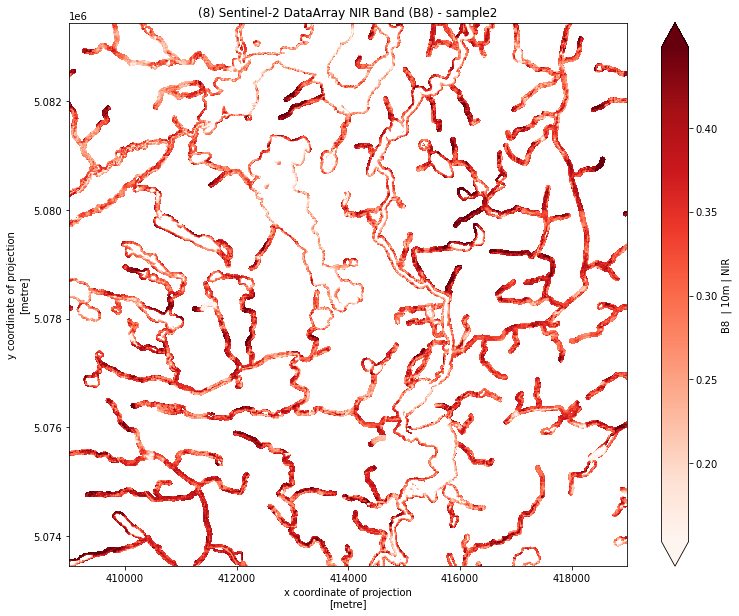

In [57]:
# Plot the NIR band
# ---------------------

# Plot the image
nir_da.plot.imshow(figsize=(12.5,10), robust=True, cmap=plt.cm.Reds)

# Add plot elements
plt.title(f"(8) Sentinel-2 DataArray NIR Band (B8) - {sample}")

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"7-riparian_buffer-NIR_band-{sample}.png")
plt.savefig(fig_path)

## 8) Calculate NDVI

Authors: Haley, John

In [58]:
# Calculate NDVI DataArray
# ------------------------

ndvi_da = (nir_da - red_da) / (nir_da + red_da)
ndvi_da.attrs["long_name"] = "NDVI (Normalized Difference Vegetation Index)"

# Save the intermediate output
ndvi_da_path = os.path.join(intermed_imagery_path,
                            f"8-riparian_buffer-NDVI-{sample}.tiff")                       
ndvi_da.rio.to_raster(ndvi_da_path)

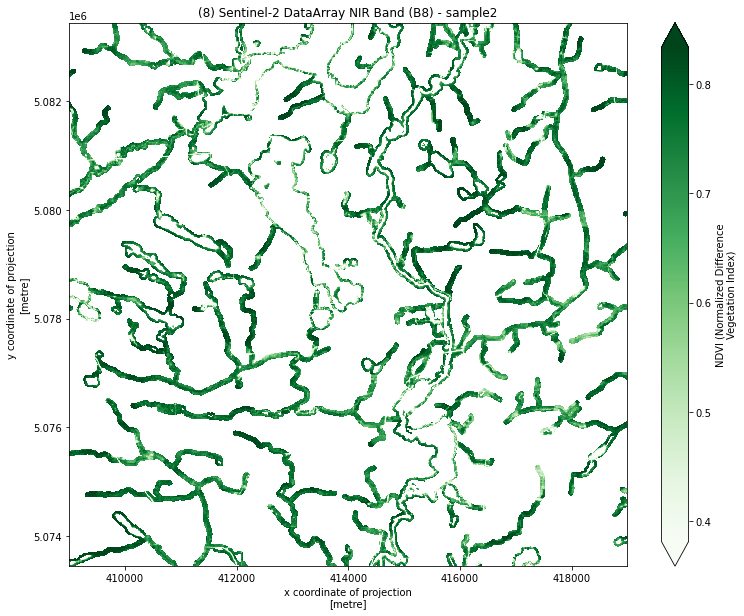

In [59]:
# Plot the NDVI DataArray
# -----------------------

# Plot the image
ndvi_da.plot.imshow(figsize=(12.5,10), robust=True, cmap=plt.cm.Greens)

# Add plot elements
plt.title(f"(8) Sentinel-2 DataArray NIR Band (B8) - {sample}")

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"8-riparian_buffer-NDVI-{sample}.png")
plt.savefig(fig_path)

## 9) Determine NDVI Threshold

Authors: Taji, John

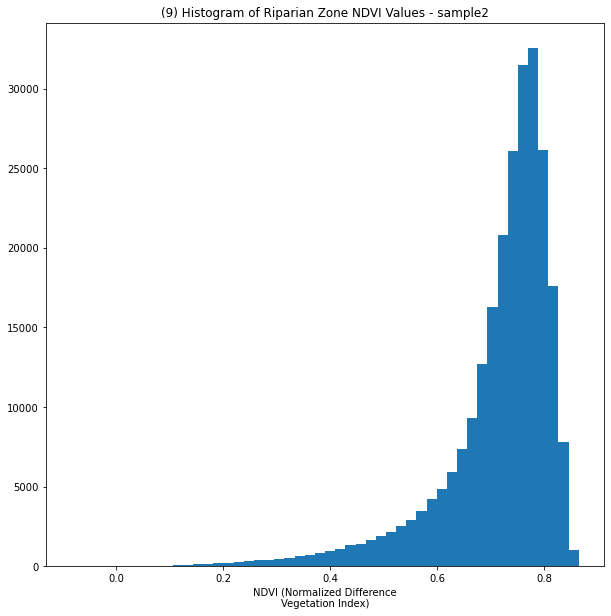

In [60]:
# Plot a histogram of the NDVI DataArray to investigate an appropriate threshold
# -------------------------------------------------------------------------------

ndvi_da.plot.hist(bins=50, figsize=(10,10))

# Add plot elements
plt.title(f"(9) Histogram of Riparian Zone NDVI Values - {sample}")

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"9-NDVI-histogram-{sample}.png")
plt.savefig(fig_path)

## 10) Create Binary Riparian Vegetation DataArray

Authors: Taji, John

In [61]:
# Specify a threshold and create a binary riparian vegetation DataArray
# ------------------------------------------------------------------------

# User input NDVI threshold
threshold = 0.4

# Boolean vegetation DataArray
veg_da = (ndvi_da > threshold)

# Binary vegetation DataArray (must be float32 for converstion to vector)
veg_da = veg_da.astype('float32')

# Save the intermediate output
veg_da_path = os.path.join(intermed_imagery_path,
                           f"10-riparian_buffer-vegetation-{sample}.tiff")                       
veg_da.rio.to_raster(veg_da_path)

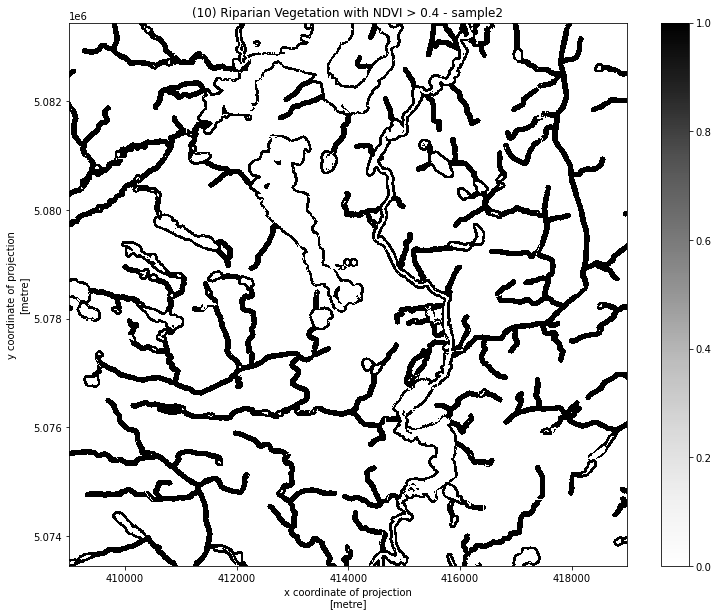

In [62]:
# 10 - Plot the riparian vegetation DataArray
# -------------------------------------------

# Plot the image
veg_da.plot.imshow(figsize=(12.5,10), cmap="Greys")

# Add plot elements
plt.title(f"(10) Riparian Vegetation with NDVI > {threshold} - {sample}")

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"10-riparian_buffer-vegetation-{sample}.png")
plt.savefig(fig_path)

## 11) Create a Binary Riparian Not-Vegetation DataArray

Authors: Taji, John

In [63]:
# Create a binary riparian not-vegetation DataArray
# ----------------------------------------------------

# Boolean not vegetation DataArray
not_veg_da = ndvi_da < threshold

# Binary not vegetation DataArray (must be float32 for converstion to vector)
not_veg_da = not_veg_da.astype('float32')

# Save the intermediate output
not_veg_da_path = os.path.join(intermed_imagery_path,
                               f"11-riparian_buffer-not_vegetation-{sample}.tiff")                       
not_veg_da.rio.to_raster(not_veg_da_path)

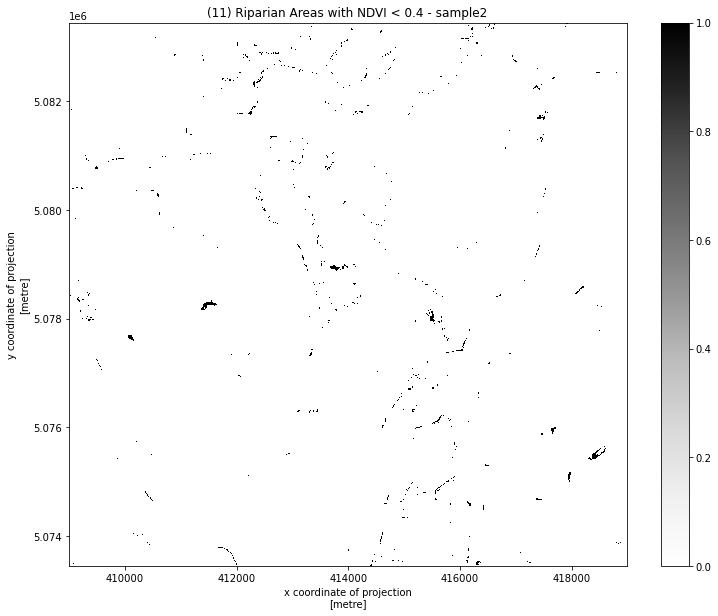

In [64]:
# Plot the riparian not vegetation DataArray
# ---------------------------------------------

# Plot the image
not_veg_da.plot.imshow(figsize=(12.5,10), cmap="Greys")

# Add plot elements
plt.title(f"(11) Riparian Areas with NDVI < {threshold} - {sample}")

# Save figure
fig_path = os.path.join(intermed_figures_path,
                        f"11-riparian_buffer-not_vegetation-{sample}.png")
plt.savefig(fig_path)

## 12) Combine Vegetation / Not-Vegetation DataArrays

Authors: Taji, John

In [65]:
# Create a riparian vegetation/not vegeation DataArray
# ----------------------------------------------------

riparian_da = veg_da - not_veg_da

riparian_da_path = os.path.join(intermed_imagery_path,
                                f"13-riparian_buffer-vegetation_not_vegetation-{sample}.tiff")                       
riparian_da.rio.to_raster(riparian_da_path)

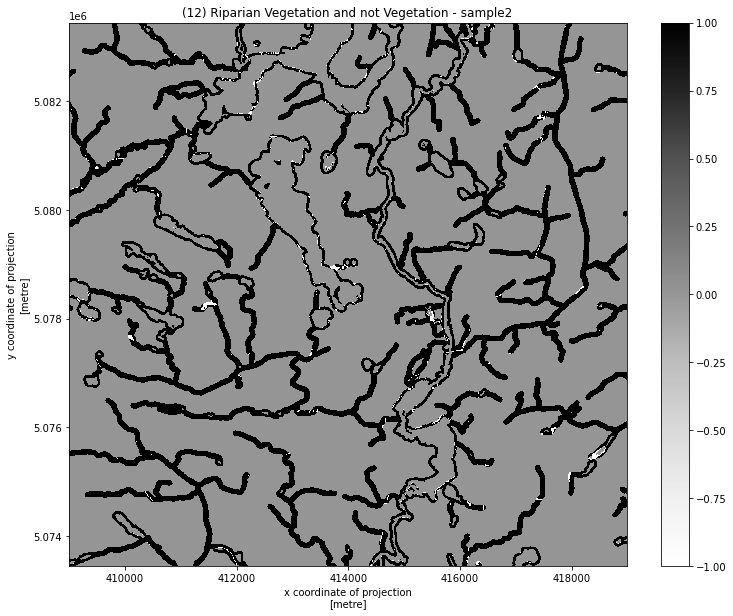

In [66]:
# Plot the riparian vegetation/not vegeation DataArray
# ----------------------------------------------------
# Plot the image
riparian_da.plot.imshow(figsize=(12.5,10), cmap="Greys")

# Add plot elements
plt.title(f"(12) Riparian Vegetation and not Vegetation - {sample}")

fig_path = os.path.join(intermed_figures_path,
                        f"12-riparian_buffer-vegetation_not_vegetation-{sample}.png")
plt.savefig(fig_path)

## 13) Convert Vegetation / Not-Vegetation DataArray to Polygon Features

Authors: John

In [67]:
# Function to convert raster to vector
# ------------------------------------

def extract_raster_features(da, n_jobs=-1):
    """Generate a geodataframe from raster data by polygonizing contiguous pixels with
    the same value 
    
    Modified from: https://pysal.org/tobler/_modules/tobler/dasymetric/raster_tools.html
    """
    
    import ast
    from rasterio import features, transform
    import multiprocessing
    from joblib import Parallel, delayed
    from shapely.geometry import shape
    
    def _chunk_dfs(geoms_to_chunk, n_jobs):
        chunk_size = geoms_to_chunk.shape[0] // n_jobs + 1
        for i in range(n_jobs):
            start = i * chunk_size
            yield geoms_to_chunk.iloc[start : start + chunk_size]
    
    def _apply_parser(df):
        return df.apply(_parse_geom)

    def _parse_geom(geom_str):
        return shape(ast.literal_eval(geom_str))

    # CRS of the DataArray
    raster_crs = da.rio.crs
    
    # Convert regions to polygons
    shapes = list(features.shapes(da.values, transform=da.rio.transform()))

    # Get number of processes for multiprocessing
    if n_jobs == -1:
            n_jobs = multiprocessing.cpu_count()
    
    res = list(zip(*shapes))
    geoms = pd.Series(res[0], name="geometry").astype(str)
    pieces = _chunk_dfs(geoms, n_jobs)
    geoms = pd.concat(
        Parallel(n_jobs=n_jobs)(delayed(_apply_parser)(i) for i in pieces))
    
    geoms = gpd.GeoSeries(geoms).buffer(0)  # we sometimes get self-intersecting rings
    vals = pd.Series(res[1], name="value")
    gdf = gpd.GeoDataFrame(vals, geometry=geoms, crs=raster_crs)
    
    return gdf

In [68]:
# Convert binary vegetation DataArray to GeoDataFrames
# -----------------------------------------------------

riparian_gdf = extract_raster_features(riparian_da)

# Extract riparian buffer vegetation
veg_gdf = riparian_gdf.loc[(riparian_gdf['value'] == 1)]

# Extract riparian buffer not vegetation
not_veg_gdf = riparian_gdf.loc[(riparian_gdf['value'] == -1)]

# Save the intermediate output
veg_gdf.to_file(filename=intermed_gpkg_path,
                     layer=f"13-riparian_vegetation-{sample}")

not_veg_gdf.to_file(filename=intermed_gpkg_path,
                     layer=f"13-riparian_not_vegetation-{sample}")

/Users/johnofoster/opt/miniconda3/envs/riparian_dev/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/johnofoster/opt/miniconda3/envs/riparian_dev/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


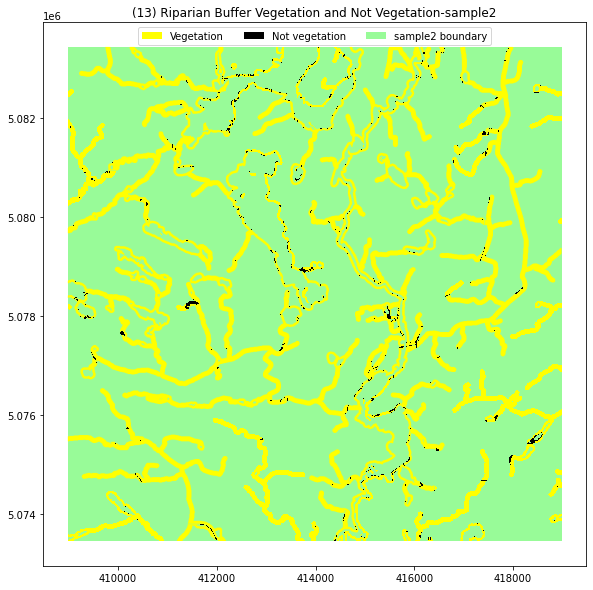

In [69]:
# Plot the vegetation and not-vegetation
# ----------------------------------

# Layer styles
boundary_style = {"facecolor": "palegreen",
                  "edgecolor": "none",
                  "label": f"{sample} boundary"}

veg_style = {"facecolor": "yellow",
             "edgecolor": "none",                
             "label": f"Vegetation"}

not_veg_style = {"facecolor": "black",
                 "edgecolor": "none",                
                 "label": f"Not vegetation"}


# Plot figure
ax = boundary_gdf.plot(color=boundary_style["facecolor"],
                       label=boundary_style["label"],
                       figsize=(10, 10),
                       legend_kwds={'loc': 'center left'})

veg_gdf.plot(ax=ax,
             color=veg_style["facecolor"],
             label=veg_style["label"],
             linewidth=0.5)

not_veg_gdf.plot(ax=ax,
                 color=not_veg_style["facecolor"],
                 label=not_veg_style["label"],
                 linewidth=0.5)

# Add figure elements
ax.set_title(label=f"(13) Riparian Buffer Vegetation and Not Vegetation-{sample}")

# Create polygon legend elements
veg_handle = Patch(**veg_style)
not_veg_handle = Patch(**not_veg_style)
boundary_handle = Patch(**boundary_style)
handles, _ = ax.get_legend_handles_labels()

# Add legend
ax.legend(loc="upper center", ncol=4,
          handles=[*handles,
                   veg_handle,
                   not_veg_handle,
                   boundary_handle])

# Save figure
fig_path = os.path.join(intermed_figures_path, f"13-riparian_vegetation_and_not_vegetation-{sample}.png")
plt.savefig(fig_path)

## 14) Calculate Riparian Connectivity Statistics

Authors: Taji, John

This will need to be refactored so the whole script can be looped over multiple watersheds and the results of each watershed compiled into the table. This version is merely for exploratory testing purposes.

In [70]:
# Calculate stats
# ---------------

# Perimeters
veg_perimeter = veg_gdf['geometry'].length.sum() / 1000
not_veg_perimeter = not_veg_gdf['geometry'].length.sum() / 1000

# Areas
veg_area = veg_gdf['geometry'].area.sum() / 1_000_000
not_veg_area = not_veg_gdf['geometry'].area.sum() / 1_000_000

# n features
veg_n_features = len(veg_gdf)
not_veg_n_features = len(not_veg_gdf)


In [71]:
# Create stats DataFrame
# ----------------------

riparian_stats_df = pd.DataFrame({"Veg area (km2)": [veg_area],
                                  "Not veg area (km2)": [not_veg_area],
                                  "Veg perimeter (km)": [veg_perimeter],
                                  "Not veg perimeter (km)": [not_veg_perimeter],
                                  "Veg n features": [veg_n_features],
                                  "Not veg n features": [not_veg_n_features],
                                  "Not veg n features / riparian area":
                                  [(not_veg_n_features / (veg_area + not_veg_area))],
                                  
                                  "Not veg perimeter / veg perimeter":
                                  [(not_veg_perimeter / veg_perimeter)]},
                                index=[sample])


# Save intermediate results

intermed_tables_path
table_path = os.path.join(intermed_tables_path,
                          f"14-riparian_connectivity_stats-{sample}.csv")

riparian_stats_df.to_csv(table_path)

# Print results                                  
print(sample)
riparian_stats_df

sample2


,Veg area (km2),Not veg area (km2),Veg perimeter (km),Not veg perimeter (km),Veg n features,Not veg n features,Not veg n features / riparian area,Not veg perimeter / veg perimeter
sample2,17.602862,0.417409,603.0772,84.923185,128,1025,56.880388,0.140816
